In [ ]:
import numpy as np
import schemdraw
import schemdraw.elements as elm
from modelling import gen_signals
import matplotlib.pyplot as plt
import rich

: 

In [14]:
# Physical Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)

# Plot Parameters

In [15]:
from matplotlib import rcParams

plt.style.use('./custom_dark_bg.mplstyle')


# Model Electrode

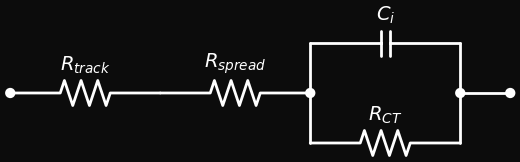

In [18]:
schemdraw.config(color='white')
with schemdraw.Drawing() as d:
    d.config(unit=3)

    d += elm.Dot(open=True)  # left terminal
    d += elm.Resistor().label("$R_{track}$")  # r_track
    d += elm.Resistor().label("$R_{spread}$")  # r_spread

    left_node = d.add(elm.Dot())  # branch point

    # capacitive branch
    d += elm.Line().down().length(1).at(left_node.center)
    d += elm.Resistor().right().length(3).label("$R_{CT}$")
    d += elm.Line().up().length(1)

    # resistive branch (faradaic)
    d += elm.Line().up().length(1).at(left_node.center)
    d += elm.Capacitor().right().length(3).label("$C_i$")
    d += elm.Line().down().length(1)

    right_term = d.add(elm.Dot())  # end branch point

    d += elm.Line().right().length(1)
    d += elm.Dot(open=True)  # right terminal

fig = d.draw()

## Waveform and Charge Injection

In [19]:
PRF = 33 # Hz
PRP = 1 / PRF # s
burst_duration = 250e-6 # s
carrier_freqs = np.array([20e3, 22e3]) # Hz
carrier_amplitudes = np.array([1e-3, 1e-3]) # A

In [20]:
ts = 1e-6  # s, sampling time step
burst_t = np.arange(0, burst_duration, ts).reshape(-1, 1)  # time vector for one burst
burst_signals = gen_signals(carrier_freqs, carrier_amplitudes, burst_t)  # generate burst signals

In [ ]:
# Calculate injected charge
# Let's consider injected charge to be the integral of the stimulation burst over its cathodic phase

# 1) Restrict bursts to cathodic phase
def cathodic_signal_phase(burst_signals):
    cathodic_phase_mask = burst_signals <= 0
    cathodic_signal = cathodic_phase_mask.astype(int) * burst_signals
    return cathodic_signal

cathodic_signal = cathodic_signal_phase(burst_signals)

# 2) Calculate the integral over the cathodic phase
injected_charge = np.trapezoid(cathodic_signal, dx=ts, axis=0)
print(f'During each burst, ~{(injected_charge * 1e6)} μC should be injected for, respectively, the {carrier_freqs * 1e-3} kHz electrode, assuming a 0.5 steering ratio.')

max_injected_charge = np.trapezoid(cathodic_signal_phase(gen_signals(carrier_freqs, np.array([2e-3, 2e-3]), burst_t)), dx=ts, axis=0)
print(f'If we assume instead a steering ratio of ~1 or ~0, the injected charges would be, per electrode/frequency, {max_injected_charge * 1e6} μC respectively, which is still within the same order of magnitude. This would be the maximum within our stimulation parameter space.')

# 3) Approximate required charge injection capacity
# Let's assume each electrode is 1mm^2. 
# Furthermore, let's assume we're at the maximum required injection, and let's say we direct all current to a single electrode.

A = 1e-2 #cm^2
required_CIC = max_injected_charge/A
print(f'The minimum required Charge Injection Capacity (CIC) is {(required_CIC * 1e6)} μC/cm^2, respectively for the carrier frequencies {carrier_freqs * 1e-3} kHz, assuming we concentrate all current in a single electrode.')

# Missing: power calculations.


During each burst, ~[0.07947272 0.08679922] μC should be injected for, respectively, the [20. 22.] kHz electrode, assuming a 0.5 steering ratio.
If we assume instead a steering ratio of ~1 or ~0, the injected charges would be, per electrode/frequency, [0.15894545 0.17359843] μC respectively, which is still within the same order of magnitude. This would be the maximum within our stimulation parameter space.
The minimum required Charge Injection Capacity (CIC) is [15.89454484 17.35984342] μC/cm^2, respectively for the carrier frequencies [20. 22.] kHz, assuming we concentrate all current in a single electrode.


Text(0.5, 1.0, 'Stimulation waveform per electrode/frequency')

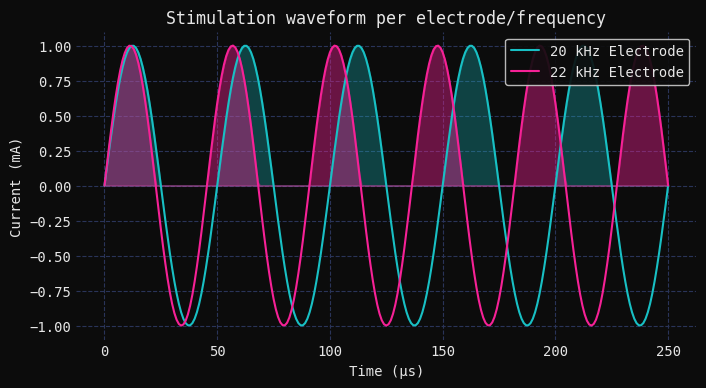

In [ ]:
# Illustration of Charge Injection calculation

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(burst_signals * 1e3, label=[f'{f * 1e-3:.0f} kHz Electrode' for f in carrier_freqs])
ax.fill_between(np.arange(len(cathodic_signal)), 0, cathodic_signal[:,0] * 1e3, color='C0', alpha=0.3)
ax.fill_between(np.arange(len(cathodic_signal)), 0, cathodic_signal[:,1] * 1e3, color='C1', alpha=0.4)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Current (mA)')
ax.legend(loc='upper right')
ax.set_title('Stimulation waveform per electrode/frequency')

# Electrode interface
$$C_i = C_H + C_{GC}$$
$$\frac{1}{C_1} = \underbrace{t_{dl} (\epsilon_0 \epsilon_r)^{-1}}_{C_H} + \underbrace{L_D (\epsilon_0 \epsilon_r)^{-1} cosh^{-1} (\frac{z \cdot E_p}{2 \cdot V_t})}_{C_{GC}}$$
$$L_D = \sqrt{\frac{\epsilon_0 \epsilon_r V_t}{2 n^0 z^2 q}}$$

| Parameter | Value |
| --------- | ----- |
| $t_dl$    | $5 \cdot 10^{10}$ m |
| $z$       | $4$   |
| $V_t$     | $0.0259$ V |
|$n^0$      | $93 \cdot 10^{25}$ ions/$m^3$|
| q         | $1.602 \cdot 10^{-19}$ C |

Equations and reference values from [Franks et al., 2005](https://doi.org/10.1109/tbme.2005.847523).

In [23]:
t_dl = 5e10 # m
z = 4
V_t = 0.0259 # V
n0 = 93e25 # ions/m^3
q = 1.602e-19 # C

In [24]:
def R_track(R_s, L, W):
    return R_s * (L / W)


def R_spread(rho_medium, r):
    return (rho_medium) / (4 * r)


def C_H(t_dl, epsilon_r):
    C_H = (epsilon_0 * epsilon_r) / t_dl
    return C_H


def C_GC(epsilon_r, L_D, z, V_t, potential):
    C_GC = (
        epsilon_0 * epsilon_r * np.cosh((z * potential) / (2 * V_t))
        ) / (
        L_D * z * V_t
    )
    return C_GC


def L_D(epsilon_r, V_t, n0, z, q):
    L_D = np.sqrt(
        (epsilon_0 * epsilon_r * V_t) / (2 * n0 * z**2 * q)
    )
    return L_D


def C_i(C_H, C_GC):
    C_i = (C_H**-1 + C_GC**-1) ** -1
    return C_i


def Z_i(C_i, f, ESA):
    omega = 2 * np.pi * f
    Z_i = 1 / (1j * omega * C_i * ESA)

    return Z_i

## Material specific constants

In [Carnicier-Lombarte et al., 2024](https://www.nature.com/articles/s41467-024-51988-1) and [Paggi et al., 2024](https://doi.org/10.1186/s42234-023-00137-y), the nerve cuff device is microfabricated with **gold tracks**.

In both cases, the *electrodes* are made of **platinum** (Pt), however, in the former, they are coated with **PEDOT:PSS**.

In [ ]:
# Gold
R_s_gold = 

